# Set Up

## Colab Installation

Run the following code block if you are using this Jupyter notebook in Google Colab. Otherwise skip to importing the packages.

In [ ]:
# Run these statements if you are using Google Colab. Otherwise skip this step.
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt install cm-super
!pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2024

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

## Importing Packages

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
figpath = '' #this path sends the figures to the directory that you want
savefigs = True  #save the figures on your disk if True
imgfrmt = 'pdf' #kind of format to save figures as

# Definitions of Functions

The following functions are things that will be repeatedly used in the notebook so that there isn't duplicate code all over the place.

## Graphing Functions

The following functions are to help with graphing.

In [3]:
def make_grid(d=3, nper=2):
    """this function creates a nper^d x d matrix of grid points"""
    xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  #array of coordinate values
    xgrid = xpts  #initial grid
    n = nper  #initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  #store the old grid
        xgrid = np.vstack((xgrid0, xpts[0] * np.ones((1, n))))  #stack the next coordinate
        for jj in range(1, nper):
            xgrid = np.hstack((xgrid, np.vstack((xgrid0, xpts[jj] * np.ones((1, n))))))
        n = n * nper  #update the length of the grid
    return xgrid.T  #take the transpose to that coordinates are columns

def plot_grid(xgrid, coord_to_plot=[0, 1], savefig=True, figpath=''):
    """Plots a dot grid."""
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot, [d, d]), #ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot, [1, 1]), #ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False)
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]), fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]), fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath + f"{n:.0f}gridpts_d{d:.0f}." + imgfrmt, format=imgfrmt)


In [4]:
def graph_kernel(bandwidths, lin_spaces, kernel, ylim_lst=[-0.05, 1.2]):
  """Graphs a given kernel, with given bandwidths, lin_spaces"""
  ypts = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  nband = len(bandwidths)
  fig, ax = plt.subplots(1, 3, figsize=(5*nband, 5))
  for ii in range(nband):
      ax[ii].plot(ypts,kernel(ypts/bandwidths[ii]) / bandwidths[ii])
      ax[ii].grid(False)
      ax[ii].set_ylim(ylim_lst)
      ax[ii].set_xlabel(r'$y$', fontsize=20)
      if (ii == 0):
          ax[ii].set_ylabel(r'$\widetilde{k}(y) = \exp(-(y/h)^2)/(\sqrt{\pi}h), \ h = {%0.1f}$'%bandwidths[ii], fontsize=20)
      else:
          ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidths[ii], fontsize=20)

In [5]:
def generate_sobol_iid_graph(bandwidths, lin_spaces, kde, kernel, yiid, ysob, ylim_lst=[-0.05, 1.2]):
  """Generates a graph using IID and Sobol sample points."""
  nband = len(bandwidths)
  yeval = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  for ii in range(nband):
      rhovaliid = kde(kernel, yiid, bandwidths[ii], yeval)
      rhovalsob = kde(kernel, ysob, bandwidths[ii], yeval)
      fig,ax = plt.subplots()
      ax.plot(yeval, rhovaliid, label = "IID")
      ax.plot(yeval, rhovalsob, label = "Sobol")
      ax.legend()
      ax.set_ylim(ylim_lst)
      ax.set_title(f"$h = {bandwidths[ii]:.2f}$")

In [6]:
def generate_graphs(bandwidths, lin_spaces, kde, kernel, sample_points, ylim_lst=[-0.05, 1.2]):
  """
  Generate graphs involving a kde, kernel, and sample_points.
  sample_points is a list of IID, Sobol, Lattice, DNB2, and Halton points.
  """
  nband = len(bandwidths)
  yeval = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  rho_list = list()
  for ii in range(nband):
      rhovaliid = kde(kernel, sample_points[0], bandwidths[ii], yeval)
      rhovalsob = kde(kernel, sample_points[1], bandwidths[ii], yeval)
      rhovallattice = kde(kernel, sample_points[2], bandwidths[ii], yeval)
      rhovaldnetb2 = kde(kernel, sample_points[3], bandwidths[ii], yeval)
      rhovalhalton = kde(kernel, sample_points[4], bandwidths[ii], yeval)
      fig, ax = plt.subplots()
      ax.plot(yeval, rhovaliid, label = "IID")
      ax.plot(yeval, rhovalsob, label = "Sobol")
      ax.plot(yeval, rhovallattice, label = "Lattice")
      ax.plot(yeval, rhovaldnetb2, label = "Digital Net B2")
      ax.plot(yeval, rhovalhalton, label = "Halton")
      ax.legend()
      ax.set_ylim(ylim_lst)
      ax.set_title(f"$h = {bandwidths[ii]:.2f}$")

## Generate Functions

The following functions are used to generate different types of sample points.

In [7]:
def gen_iid_and_sobol(dimen = 3, n = 2**12):
  """Generate IID and Sobol sample points based on given sample size and dimensions."""
  coord_wts = 2.0 ** (-np.array(range(0, dimen)))
  iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
  sobpts = qp.Sobol(dimen).gen_samples(n)
  return (iidpts, sobpts)

def gen_iid_ld_pts(dimen = 3, n = 2**12):
  """
  Generate IID, Sobol, Lattic, DNB2, and Halton sample points,
  based on dimension and smaple size.
  """
  coord_wts = 2.0**(-np.array(range(0, dimen)))
  iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
  sobpts = qp.Sobol(dimen).gen_samples(n)
  latticepts = qp.Lattice(dimen).gen_samples(n)
  dnetb2pts = qp.DigitalNetB2(dimen).gen_samples(n)
  haltonpts = qp.Halton(dimen).gen_samples(n)
  return (iidpts, sobpts, latticepts, dnetb2pts, haltonpts)

## Kernels and KDEs

The following are definitions of different kernels used in the notebook. Some may be defined later, but these are ones used throughout the notebook or commonly used/known.

The example kernel defined below represents the following:

$$
\frac{e^{-y^2}}{\sqrt{\pi}}
$$

In [8]:
def kernel_ex(y):
    return np.exp(-y * y) / np.sqrt(np.pi)

# Graphing, Testing, and Other Stuff

The following graphs the example kernel.

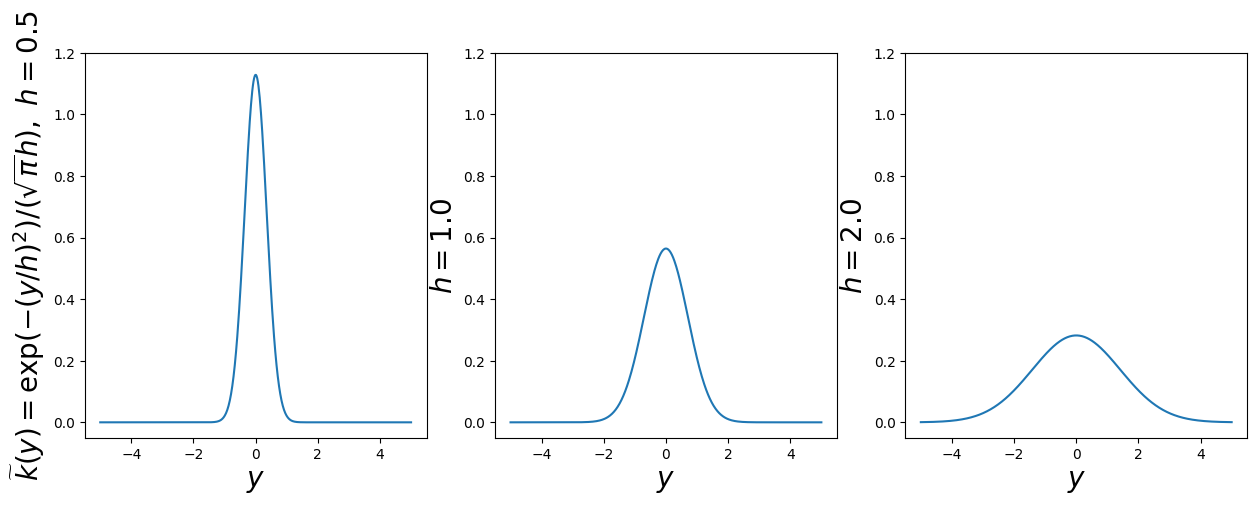

In [9]:
spaces = (-5, 5, 500)
bw = [0.5, 1, 2]
graph_kernel(bw, spaces, kernel_ex)

In [10]:
iidpts, sobpts = gen_iid_and_sobol()
print(iidpts)
print(sobpts)

[[9.67174468e-01 9.79427434e-01 3.54290653e-01]
 [9.10525126e-01 9.19508277e-01 8.40986007e-04]
 [5.91155227e-02 3.95329460e-01 9.43524703e-01]
 ...
 [5.64901870e-01 7.54701816e-01 3.54946103e-01]
 [9.96538273e-01 7.47024015e-01 1.58302401e-01]
 [9.02603486e-01 3.96961123e-01 4.94490352e-01]]
[[0.38521543 0.21862324 0.11355401]
 [0.88391676 0.68117405 0.59620352]
 [0.0553843  0.90920192 0.9690684 ]
 ...
 [0.82591352 0.97983575 0.97073894]
 [0.24626001 0.7361849  0.59457862]
 [0.74950798 0.14795305 0.11534721]]


In [11]:
def testfun1(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    y = 10 * np.exp(-wtx.sum(1)) * np.sin(np.pi * wtx.sum(1))
    #y = x[:,0] # if x is uniform, then y is uniform
    return y

In [14]:
yiid1 = testfun1(iidpts)
ysob1 = testfun1(sobpts)

The following example *Kernel Density Estimator* (KDE)

$$
\varrho() = \frac{k\left(\frac{y - Y}{h}\right)}{h}
$$

*(Still needs work.)*

In [12]:
def kde_ex(kernel, ypts, bandwidth, yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval) #values of density estimator
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts) / bandwidth)) / bandwidth
    return rhoval

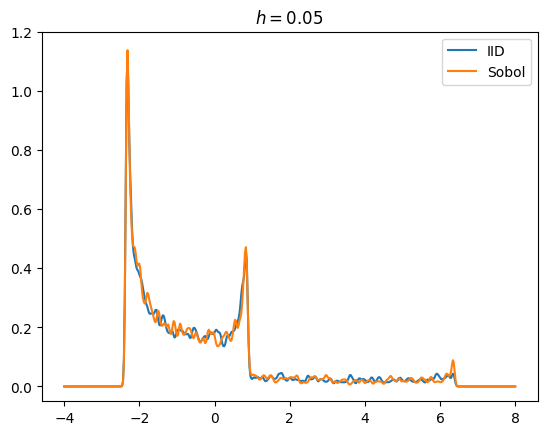

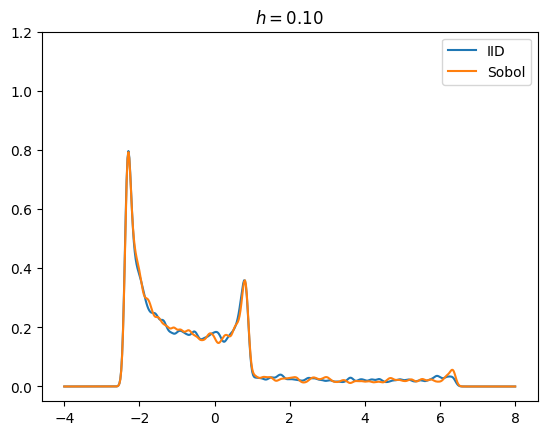

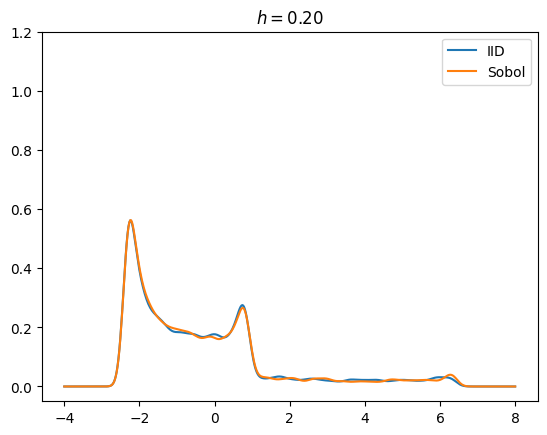

In [15]:
bw = [0.05, 0.1, 0.2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde_ex, kernel_ex, yiid1, ysob1)

# Kernel Density Estimator for Uniform Distribution

In [16]:
def testfun_unif(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    # y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    y = x[:,0] # if x is uniform, then y is uniform
    return y

In [17]:
yiid_unif = testfun_unif(iidpts)
ysob_unif = testfun_unif(sobpts)

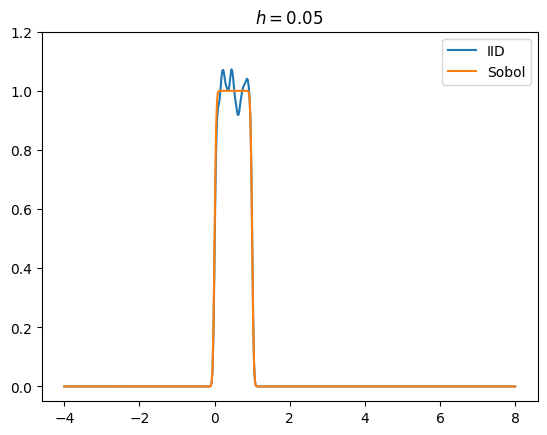

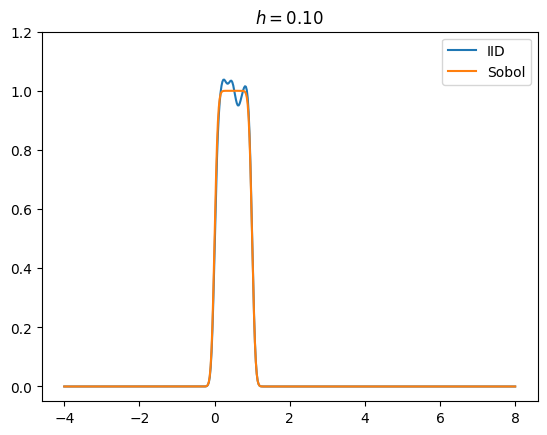

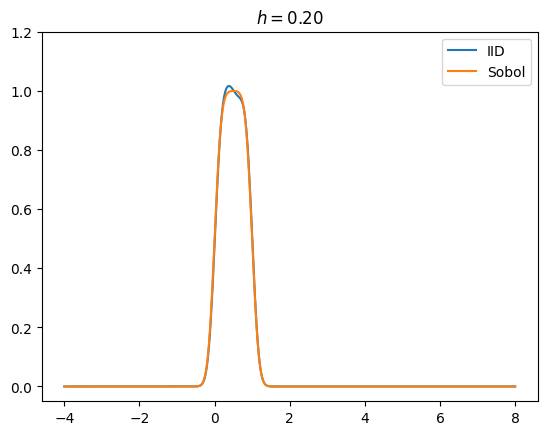

In [18]:
bw = [0.05, 0.1, 0.2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde_ex, kernel_ex, yiid_unif, ysob_unif)

# Testing Different Bandwidths

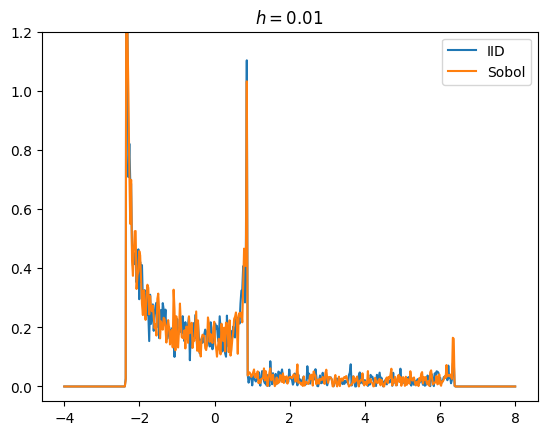

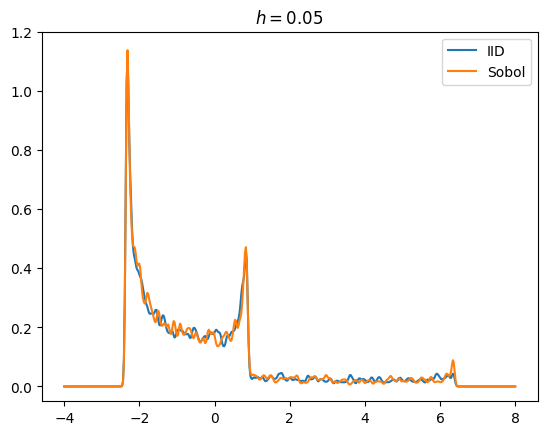

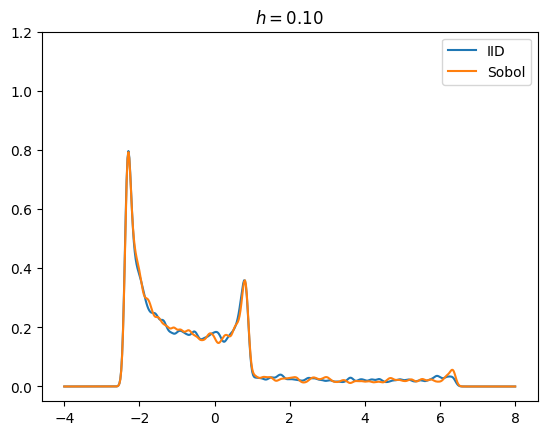

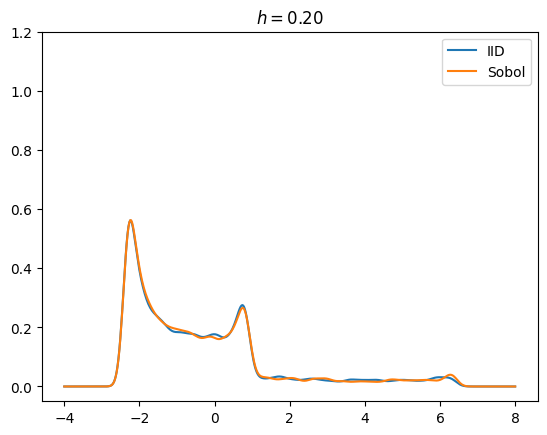

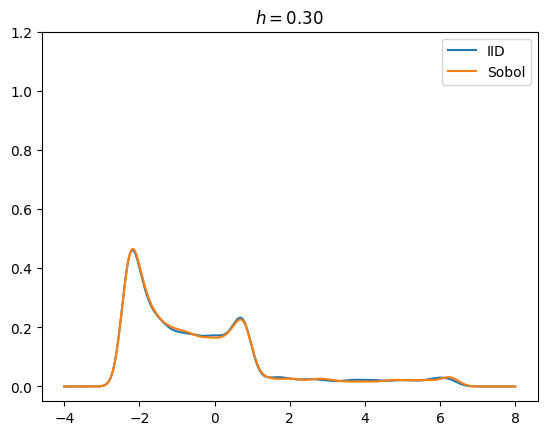

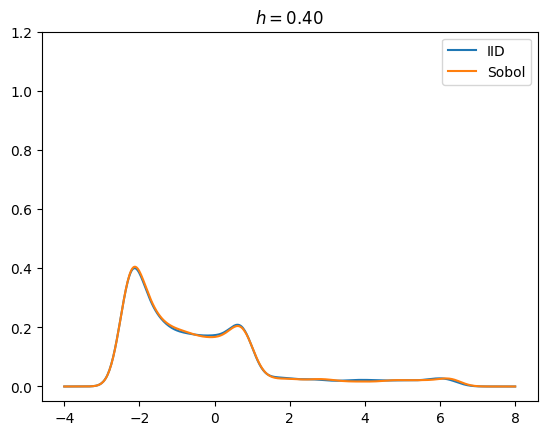

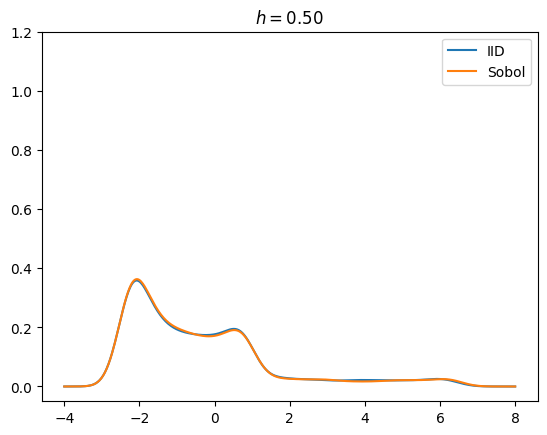

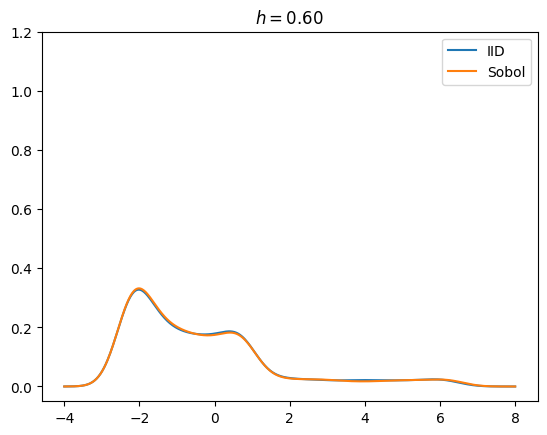

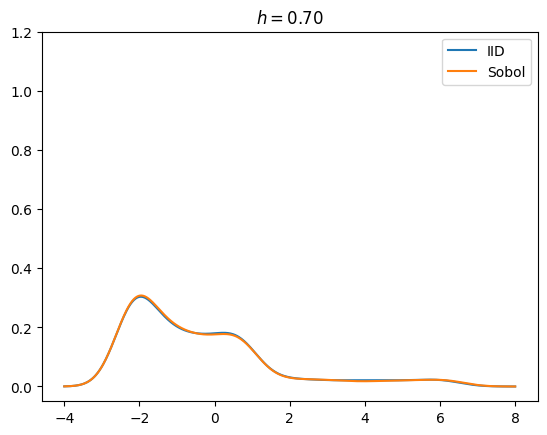

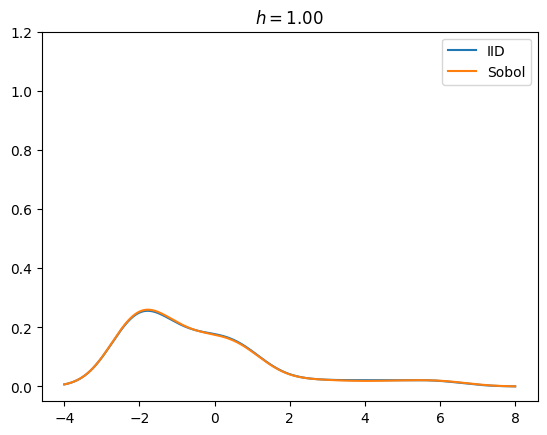

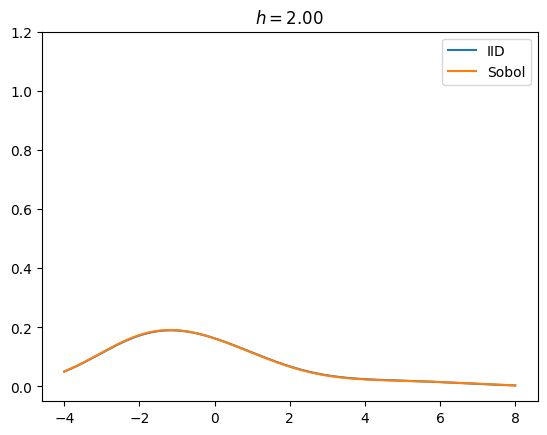

In [19]:
bw = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 2]
generate_sobol_iid_graph(bw, spaces, kde_ex, kernel_ex, yiid1, ysob1)

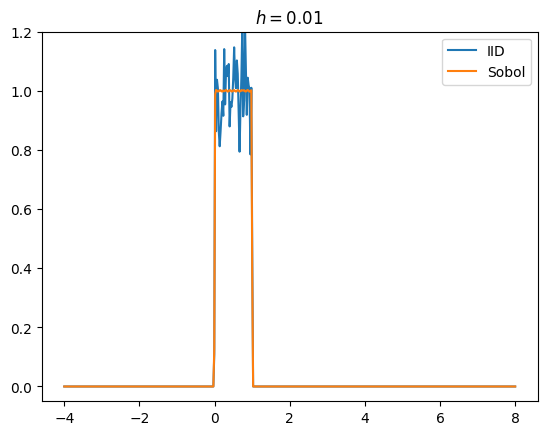

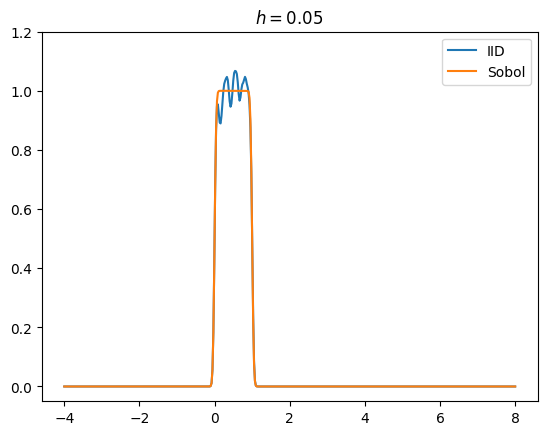

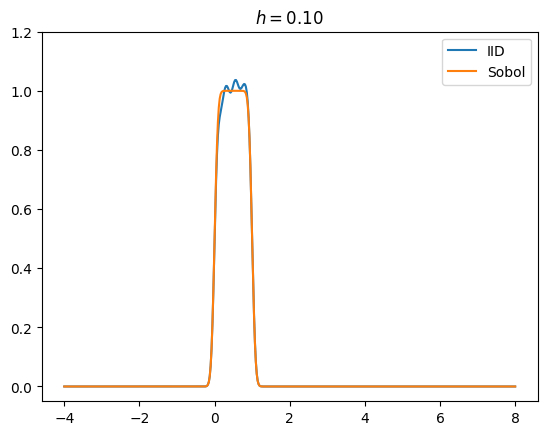

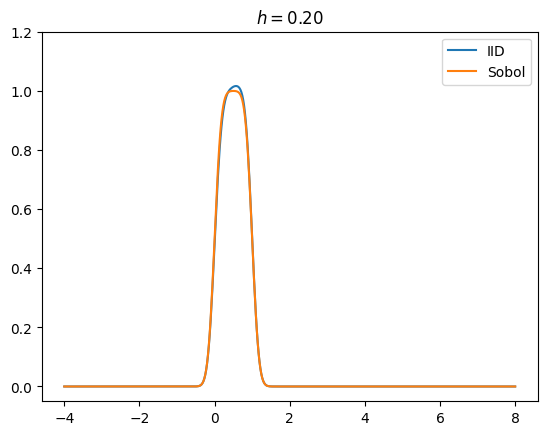

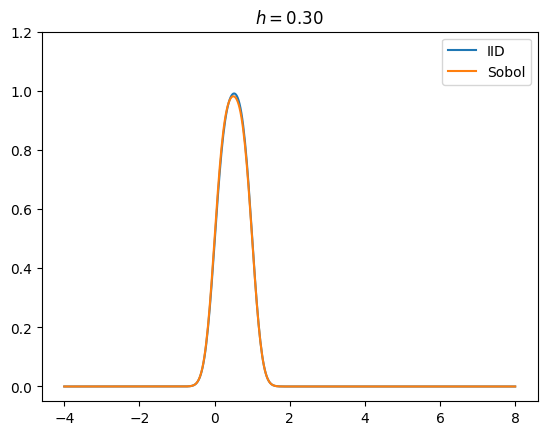

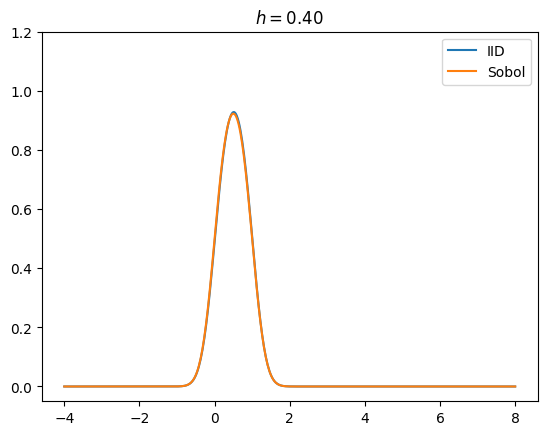

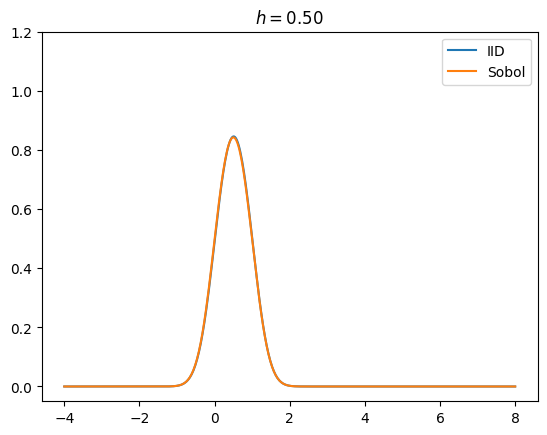

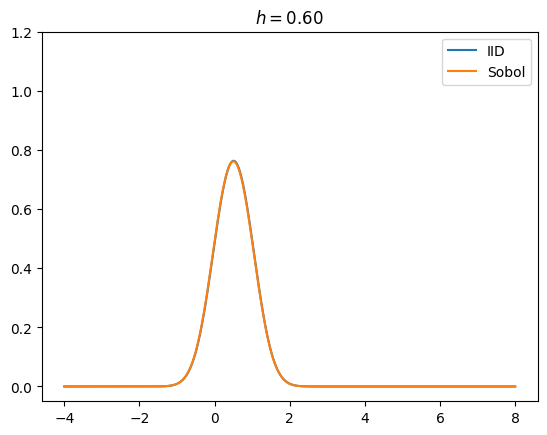

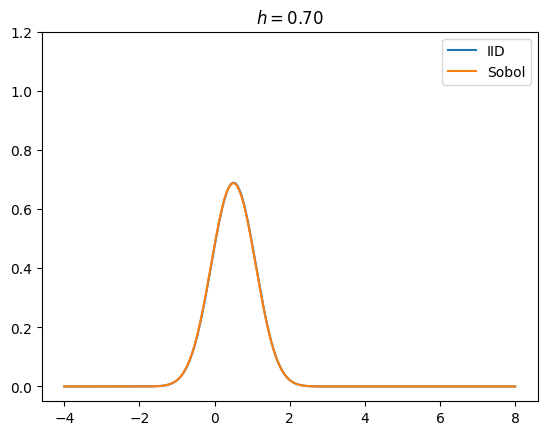

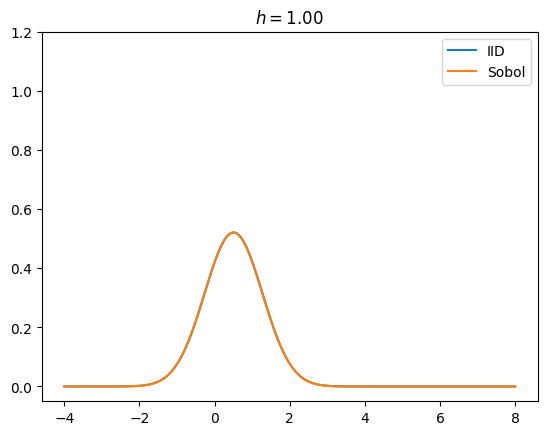

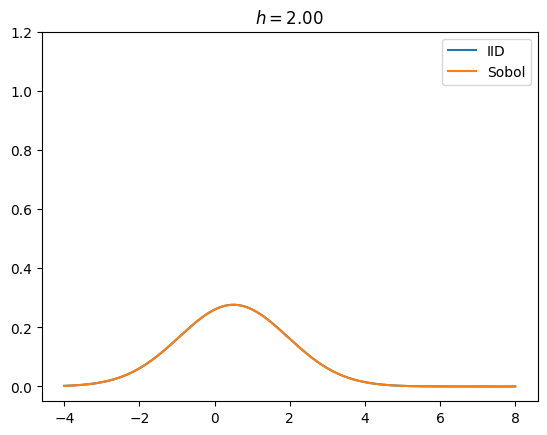

In [ ]:
generate_sobol_iid_graph(bw, spaces, kde_ex, kernel_ex, yiid_unif, ysob_unif)

# Testing different LD sequences: Sobol, Lattice, Digital Net B2, and Halton

In [ ]:
# iidpts, sobpts, latticepts, dnetb2pts, haltonpts = gen_iid_ld_pts()
points1 = gen_iid_ld_pts()

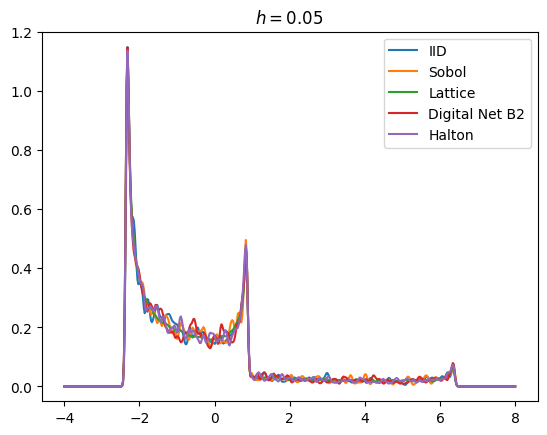

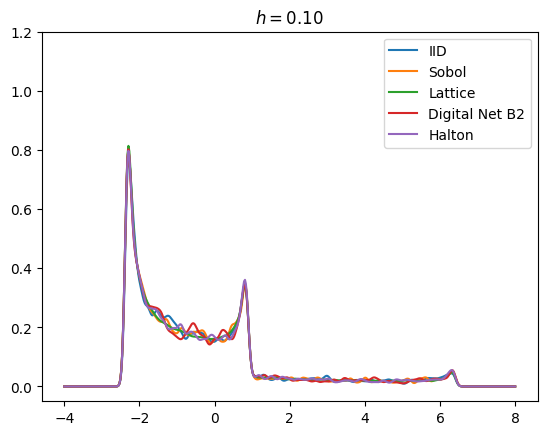

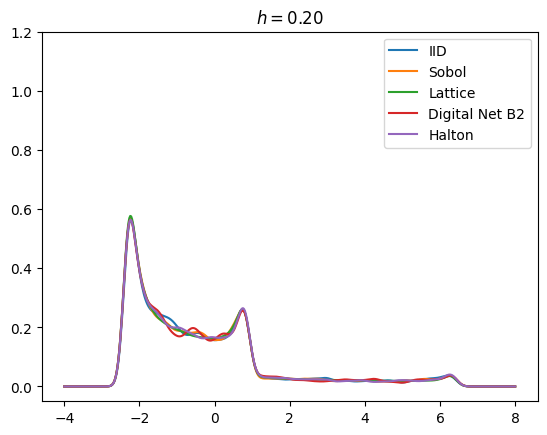

In [ ]:
# using original function f(x)

lst_points = list()

for pts in points1:
  lst_points.append(testfun1(pts))

bw = [0.05, 0.1, 0.2]
generate_graphs(bw, spaces, kde_ex, kernel_ex, lst_points)

# Different Kernels

The following Python function definition is the expression:

$$
\frac{\pi}{4}\cos\left(\frac{\pi}{2} y\right)
$$

In [ ]:
# cosine--has best performance according to paper?
def kernel_cos(y):
    return (math.pi / 4) * np.cos((math.pi/2) * y)

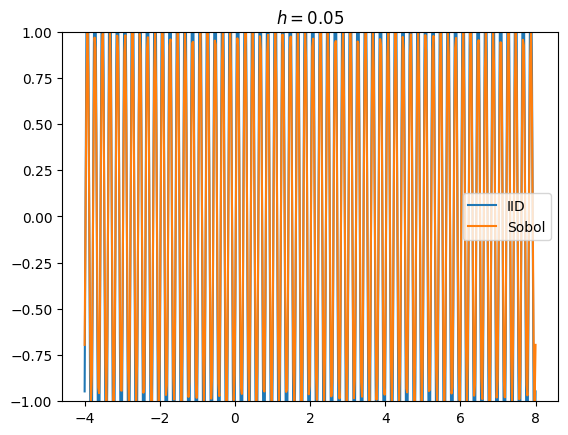

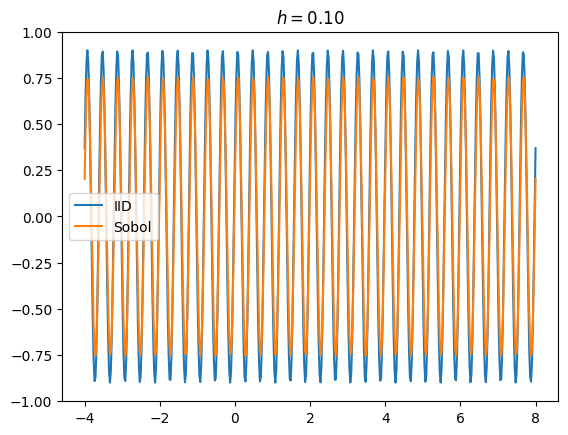

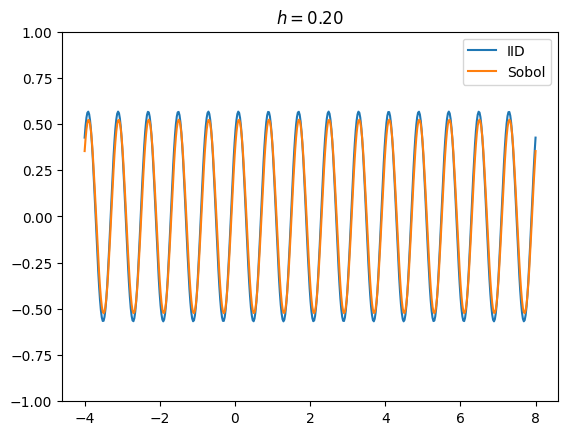

In [ ]:
bw = [0.05, 0.1, 0.2]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde_ex, kernel_cos, yiid1, ysob1, ylim_lst = [-1, 1])

The following Python function defines the kernel:

$$
0.75 (1 - y^2)
$$

In [ ]:
def kernel_ep(y):
  return 0.75 * (1 - y**2)

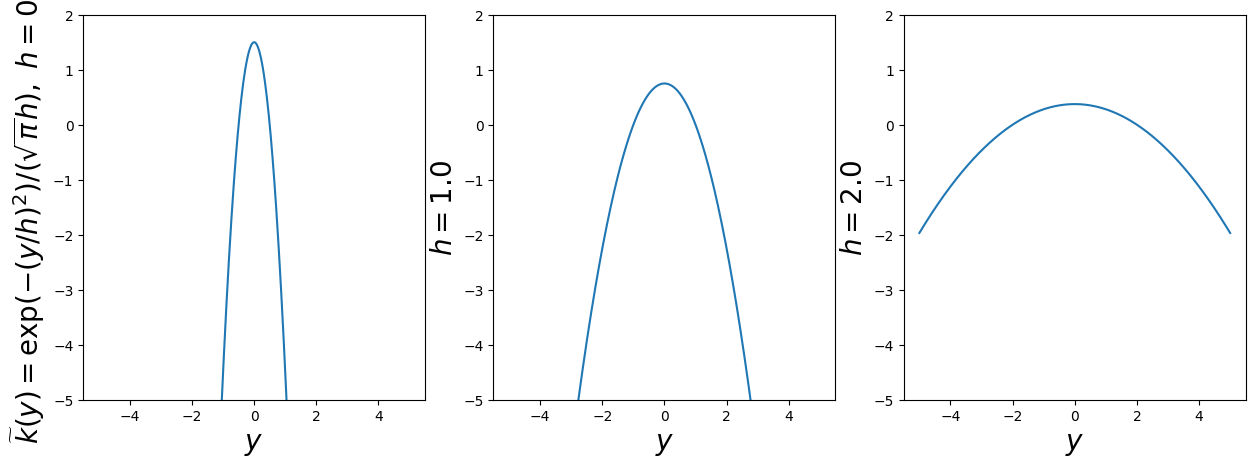

In [ ]:
graph_kernel([0.5, 1, 2], (-5, 5, 500), kernel_ep, ylim_lst = [-5, 2])

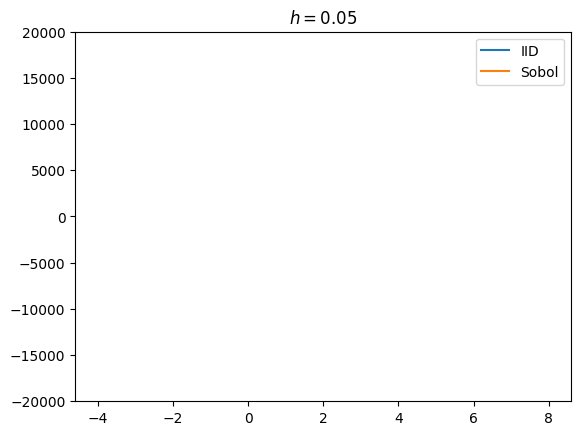

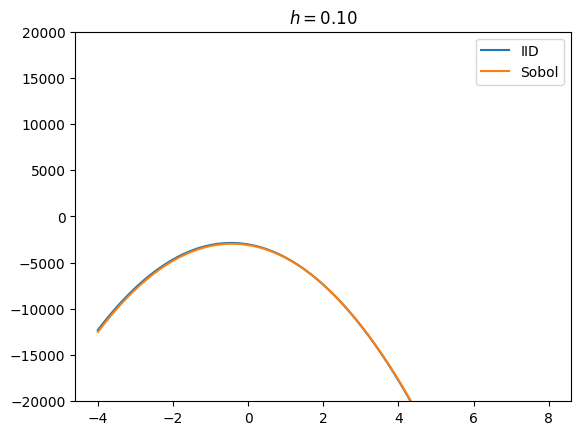

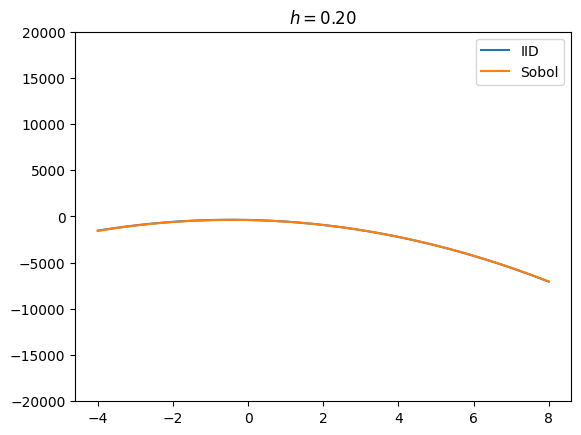

In [ ]:
generate_sobol_iid_graph([0.05, 0.1, 0.2], (-4, 8, 500), kde_ex, kernel_ep, yiid1, ysob1, ylim_lst = [-20000, 20000])

# Hermite Kernel

The following comes from Dr. Hcikernell's KDE experiment notebook.

The Hermite distribution is defined as follows:

$$
f(x):= e^{-a_1 -a_2}\sum_{j=0}^{\left \lfloor x/2 \right \rfloor}
            \frac{a_{1}^{x-2j}a_{2}^{j}}{(x-2j)!j!}.
$$

The Python definition of this is from SymPy.

In the SymPy source, under `stats/drv_types.py`, the following method part of the `HermiteDistribution` class is as follows:

```python
def pdf(self, k):
  a1, a2 = self.a1, self.a2
  term1 = exp(-(a1 + a2))
  j = Dummy("j", integer=True)
  num = a1**(k - 2*j) * a2**j
  den = factorial(k - 2*j) * factorial(j)
  return term1 * Sum(num/den, (j, 0, k//2)).doit()
```

Note that there are two factorials for the denominator. Current thought is to use Sterling's formula for possible faster computation.

# Appendix

## Todo

This section must remain at the end of the notebook. These are a list of todos that are need to be done in the notebook or research tasks. When a task is done, use double `~~` to cross it out.

- Change `graph_kernel`, `generate_sobol_iid_graph`, and `generate_graphs` arguement `ylim_lst` such that it has a default that makes sense.
- Some functions need better docstrings that are more detailed and follow PEP 257.